In [1]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import pandas as pd
from keras.utils import image_dataset_from_directory, plot_model
from keras.models import Sequential
from keras.layers import Conv2D, Dense, MaxPooling2D, AveragePooling2D, Dropout, Flatten
from keras.metrics import SparseTopKCategoricalAccuracy
from keras.callbacks import EarlyStopping

In [2]:
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Default GPU Device: /device:GPU:0


In [3]:
img_dims = (256, 256)
batch_size = 32
n_inputs = img_dims[0] * img_dims[1] * 3

train = image_dataset_from_directory(
    directory='cards/train',
    image_size=img_dims,
    batch_size=batch_size
)

val = image_dataset_from_directory(
    directory='cards/valid',
    image_size=img_dims,
    batch_size=batch_size
)

test = image_dataset_from_directory(
    directory='cards/test',
    image_size=img_dims,
    batch_size=batch_size
)

Found 7624 files belonging to 53 classes.
Found 265 files belonging to 53 classes.
Found 265 files belonging to 53 classes.


In [4]:
modelBase = Sequential()


modelBase.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    input_shape=img_dims + (3,),
    data_format="channels_last"
))


modelBase.add(Conv2D(
    filters=32,
    kernel_size=(3, 3),
    activation='relu',
    use_bias=True
))
modelBase.add(MaxPooling2D(pool_size=(2, 2)))
modelBase.add(Dropout(rate=0.2))


modelBase.add(Conv2D(
    filters=64, 
    kernel_size=(3, 3),
    activation='relu',
    use_bias=True
))
modelBase.add(MaxPooling2D(pool_size=(3, 3)))
modelBase.add(Dropout(rate=0.2))


modelBase.add(Conv2D(
    filters=128, 
    kernel_size=(3, 3),
    activation='relu',
    use_bias=True
))
modelBase.add(MaxPooling2D(pool_size=(4, 4)))
modelBase.add(Dropout(rate=0.2))


modelBase.add(Flatten())
modelBase.add(Dense(1024, activation='relu'))
modelBase.add(Dense(512, activation='relu'))
modelBase.add(Dense(128, activation='relu'))
modelBase.add(Dense(53, activation='softmax'))

modelBase.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 252, 252, 32)      9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 126, 126, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 126, 126, 32)      0         
                                                                 
 conv2d_2 (Conv2D)           (None, 124, 124, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 41, 41, 64)       0         
 2D)                                                    

In [5]:
modelBase.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy', SparseTopKCategoricalAccuracy(k=3, name = 'Top3')]
)

callbacks = [
    EarlyStopping(
        monitor="accuracy",
        min_delta=1e-4,
        patience=3,
        verbose=1,
    )
]

historyB = modelBase.fit(
    train,
    validation_data = val,
    epochs = 10000,
    callbacks = callbacks
)

Epoch 1/10000
239/239 [==============================] - 37s 131ms/step - loss: 5.5564 - accuracy: 0.2282 - Top3: 0.3965 - val_loss: 1.6306 - val_accuracy: 0.5585 - val_Top3: 0.7623
Epoch 2/10000
239/239 [==============================] - 30s 126ms/step - loss: 1.7429 - accuracy: 0.5197 - Top3: 0.7166 - val_loss: 1.1187 - val_accuracy: 0.6906 - val_Top3: 0.8453
Epoch 3/10000
239/239 [==============================] - 31s 128ms/step - loss: 1.3129 - accuracy: 0.6363 - Top3: 0.7996 - val_loss: 1.0775 - val_accuracy: 0.7019 - val_Top3: 0.8642
Epoch 4/10000
239/239 [==============================] - 30s 125ms/step - loss: 1.0382 - accuracy: 0.7049 - Top3: 0.8598 - val_loss: 0.9434 - val_accuracy: 0.7509 - val_Top3: 0.8868
Epoch 5/10000
239/239 [==============================] - 30s 124ms/step - loss: 0.8270 - accuracy: 0.7684 - Top3: 0.8985 - val_loss: 0.9952 - val_accuracy: 0.7736 - val_Top3: 0.8906
Epoch 6/10000
239/239 [==============================] - 30s 123ms/step - loss: 0.6726 - a

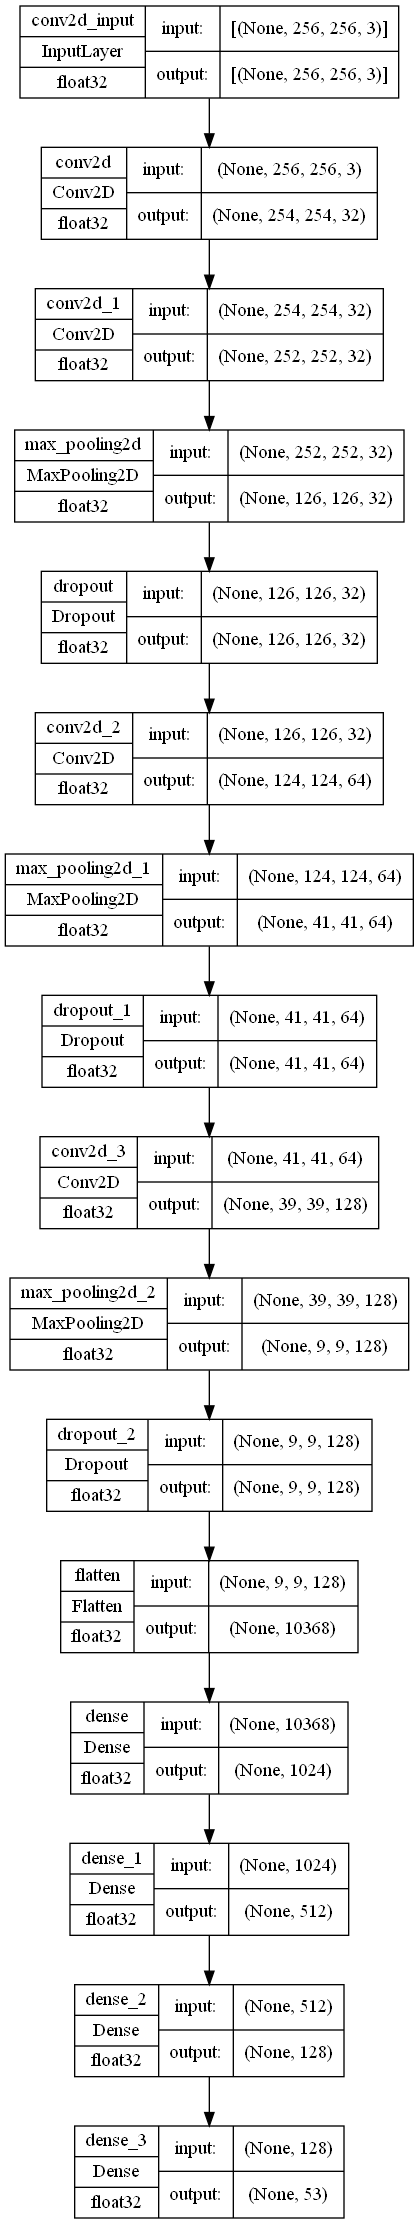

In [6]:
plot_model(
    modelBase,
    show_shapes=True,
    show_dtype=True,
    show_layer_names=True,
)

In [7]:
modelBase.evaluate(test)

9/9 [==============================] - 1s 37ms/step - loss: 1.2508 - accuracy: 0.7736 - Top3: 0.8906


[1.2508461475372314, 0.7735849022865295, 0.8905660510063171]

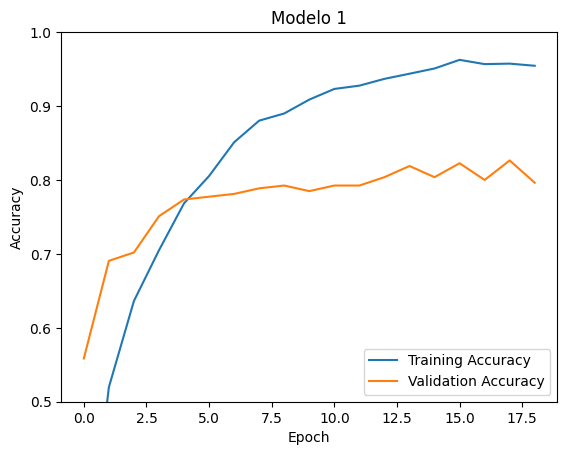

In [8]:
plt.plot(historyB.history['accuracy'], label='Training Accuracy')
plt.plot(historyB.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Modelo 1')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

In [9]:
modelBase.save_weights(input('Nombre: ')+'.h5', overwrite=True)